<b>Building a Conversational Chatbot from Scratch - Capstone Project</b><br>

**Aim of the Project**<br>
Aim of the project is to build an intelligent conversational<br>
chatbot, Riki, that can understand complex queries from<br>
the user and intelligently respond.<br>

**Background**<br>
R-Intelligence Inc., an AI startup, has partnered with an online chat and discussion website
bluedit.io. <br>R-Intelligence Inc. has an average of over 5 million active customers across the globe
and more than 100,000 active chat rooms.<br> Due to the increase in traffic, R-Intelligence Inc. are
looking to improve the user experience by using a chatbot moderator.<br> The chatbot moderator
uses a chatbot named Riki, that can help R-Intelligence Inc. customers to engage in meaningful
conversation and keep them updated on trending topics.<br> The Artificial Intelligence-powered
chat experience provides easy access to information and a host of options to the customers<br>

**Tasks to be performed**<br>
• Download the glove model available at https://nlp.stanford.edu/projects/glove/
Specification: Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, &
200d vectors, 1.42 GB download): glove.twitter.27B.zip<br>

**Importing the dependencies**<br>
We will be using numpy, sklearn, keras, tensorflow,LTSM etc packages in this exercise.
Below impoar statements will import necessary python libraries as used in this project in various places

In [0]:
import nltk, sklearn, keras
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Input, Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split

**Downloading the Global Vectors (GloVe) model project dataset**<br>
GloVe is essentially a log-bilinear model with a weighted least-squares objective. The model rests on a rather simple idea that ratios of word-word co-occurrence probabilities have the potential for encoding some form of meaning which can be encoded as vector differences.The word vectors that perform well on both word analogy tasks and on similarity tasks and named entity recognition.<br>
**Advantages**<br>
Fast training<br>
Scalable to huge corpora<br>
Good performance even with small corpus, and small vectors
Early stopping. We can stop training when improvements become small.<br>
**Drawbacks**<br>
Uses a lot of memory<br>
Sometimes quite sensitive to initial learning rate<br>


In order Download the glove model available at https://nlp.stanford.edu/projects/glove/ Specification: Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB download): glove.twitter.27B.zip , below given curl command is used. it will directly load the GloVe vector as a zip file in to Google colab's current directory /content/

In [0]:
! curl -0 http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip --output glove.twitter.27B.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1449M  100 1449M    0     0  2066k      0  0:11:58  0:11:58 --:--:-- 2099k


In below steps we will be printing current directory inside  google colab (/content/) and a new folder will be created as /cornel/cornell/ so us to accommodate the cleaned movie lines file as well as the Glove weights .h5 file , which will be downloaded in upcoming steps

In [0]:
import os
path=os.getcwd()
print("Current Directory",os.getcwd())
newDir=path+'/cornell/'
os.mkdir(newDir)
print("New Directory created as /content/cornell/")

Current Directory /content
New Directory created as /content/cornell/


One more directory will be created as /content/models/cornell/ so us to accommodate the Architecture model file in json format. This file is available in LMS  also can be downloaded from git hub repository using curl command in later steps.

In [0]:
newDir1=path+'/models/'
os.mkdir(newDir1)
newDir2=newDir1+'/cornell/'
os.mkdir(newDir2)
print("New Directory created as /content/models/cornell")

New Directory created as /content/models/cornell


Downloading below is the Movie lines cleaned file as well as Glove architecture files from GIT repository using curl command.

In [0]:
! curl -0 https://raw.githubusercontent.com/sharmasaravanan/Chat-bot/master/chatbot_train/data/cornell-dialogs/movie_lines_cleaned.txt --output /content/cornell/movie_lines_cleaned.txt
! curl -0 https://raw.githubusercontent.com/LeadingIndiaAI/Chatbot-using-Recurrent-Neural-Networks/master/support%20files/word-glove-architecture.json --output /content/models/cornell/word-glove-architecture.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16.3M  100 16.3M    0     0  10.8M      0  0:00:01  0:00:01 --:--:-- 10.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3097  100  3097    0     0  12904      0 --:--:-- --:--:-- --:--:-- 12904


Now let's try to unzip the previously downloaded glove model from zip file format to a new folder as /content/embedding_data/

In [50]:
import os
print("Current Directory",os.getcwd())
from zipfile import ZipFile
zf = ZipFile('/content/glove.twitter.27B.zip', 'r')
zf.extractall('/content/embedding_data')
zf.close()
print("Completed Extracting of files to /content/embedding_data folder")

Current Directory /content
Completed Extracting of files to /content/embedding_data folder


Defining belwo is a random state as seed(42). This will ensure the reprducability of the code for future runs.<br>
Also defining & initializing various variables such as Batch size, number of expected epochs, data path etc as it is required in various stages of the subsequent programs in coming steps.

In [0]:
RAND_STATE=np.random.seed(42)
BATCH_SIZE=64
NUM_EPOCHS=10
GLOVE_EMBEDDING_SIZE=100
DATA_PATH='/content/cornell/movie_lines_cleaned.txt'
WEIGHT_FILE_PATH='/content/cornell/word-glove-weights.h5'
DATA_SET_NAME = 'cornell'
MAX_INPUT_SEQ_LENGTH=40
MAX_TARGET_SEQ_LENGTH=40
MAX_VOCAB_SIZE=10000
HIDDEN_UNITS = 256
WHITELIST = 'abcdefghijklmnopqrstuvwxyz1234567890?.,'
GLOVE_EMBEDDING_SIZE = 100
GLOVE_MODEL = "/content/embedding_data/glove.twitter.27B.100d.txt"

Defining a while list checking function to cross verify if the input word is whitelisted or not.<br>The function returns true if the word is whitelisted otherwise False

In [0]:
def in_white_list(_word):
    for char in _word:
        if char in WHITELIST:
            return True
    return False

Now defining a new function as load_glove_vector(). This function will help us in opening the Glove model file from embedding_data foelder in to a dictionary where the **key** a **unique token** and the value is a **d** dimension vector. Since we have initialized the Glove model file with a value as glove.twitter.27B.100d.txt, the coorresponding 100 dimension vector will be loaded in to this dictionary and teh function will return this _word2embedding dictionary file when ever this function is being invoked explicitly


In [0]:
def load_glove_vector():
    file = open(GLOVE_MODEL, "r", encoding="utf8")
    _word2embedding = {}
    for line in file:
        data = line.strip().split(" ")
        _word2embedding[data[0]] = data[1:]
    file.close()
    return _word2embedding

**Data Preparation**<br>In below steps we will be filtering the conversations till maximum word length and converting the
dialogues pairs into input text and target texts. Also adding a start and end token to recognize the
beginning and end of the sentence token <br>

**Test 1**

In [0]:
word2embedding=load_glove_vector()

**Check 1**<br> Now check is performed to ensure that the load vector is loaded correclty and is not throwing any errors. Any errors will be caught during assertion chekc and assert error will be thrown. The output streaming has been limited to 5000 lines at the max.

In [55]:
assert len(word2embedding.keys())-1==1193513
for key in word2embedding.keys():
  try:
    assert len(word2embedding[key])+1==100
  except AssertionError:
    print(key,len(word2embedding[key]))


Streaming output truncated to the last 5000 lines.
اسألتي 100
اعداءك 100
اقتسم 100
اقليمية 100
اكيدة 100
الأخــلاق 100
الأخلاقn 100
الأصفرين 100
الاتحاد_vs_الهلال 100
الاتفاقي 100
الاستقامه 100
الامسَ 100
الانوااار 100
البازعي 100
البصريّ 100
البععض 100
البكاءُ 100
البوفلاسه 100
البيتِ 100
التويتريون 100
الجهراءn 100
الجوهرى 100
الجٌمَيل 100
الجَمميل 100
الحاضرات 100
الحبتين 100
الحريه_لطلاب_صيدله_المنصوره 100
الدبيخي 100
الذِكرَيات 100
الرابية 100
الرايد 100
السببnn 100
السرعات 100
السعــادة 100
السعودية_اندونيسيا 100
السنينnواحمل 100
السومه 100
السَما 100
الشعوور 100
الصحفيون 100
الضِياء 100
العاتيه 100
العشَق 100
الــطــيــبـة 100
الـمـاضـي 100
الفتيآتّ 100
الفسقة 100
الفضلِ 100
الفـجر 100
الفقرn 100
الفلشر 100
الفودري 100
الفَرحّ 100
القدوسى 100
الكلامية 100
الكوراني 100
اللــى 100
اللهم_انصر_اخواننا_المجاهدين_في_سوريا 100
اللَّهُمَ 100
المتعثرين 100
المتفرد 100
المحتاجnتحده 100
المرشدون 100
المزاجات 100
المطآر 100
المكافأت 100
الملفقة 100
المهرب 100
الموثق 100
المَشَاعِر 100
المَو

**Data Preparation**<br>In subsequent steps we will do Datapreparation techniques so us to filter the conversation , word embedding, word tokenization etc.

In [0]:
from collections import Counter
target_counter=Counter()
lines=open(DATA_PATH,'rt',encoding='utf-8').read().split('\n')
input_texts=[]
target_texts=[]
prev_words=[]

In below steps we will be **Filtering** the conversation till max length and is converting the dialogue pairs into input and target texts. <br>Put **Start** and **End** is being added as a token to recognize the begning and end of the sentence token.

In [57]:
import nltk
nltk.download('punkt')
for line in lines:
  next_words=[w.lower() for w in nltk.word_tokenize(line)]
  if len(next_words) > MAX_TARGET_SEQ_LENGTH:
    next_words=next_words[0:MAX_TARGET_SEQ_LENGTH]
  if len(prev_words) >0:
    input_texts.append(prev_words)
    target_words=next_words[:]
    target_words.insert(0,'start')
    target_words.append('end')
    for w in target_words:
      target_counter[w] +=1
    target_texts.append(target_words)
  prev_words=next_words  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Print some of the training examples**<br>
Now let's print first 10 key words so us to output and visualize the effects effects of the word tokenization which is being done in previous step.

In [58]:
for idx,(input_words, target_words) in enumerate(zip(input_texts,target_texts)):
  if idx>10:
    break
  print([input_words,target_words])

[['they', 'do', 'not', '!'], ['start', 'they', 'do', 'to', '!', 'end']]
[['they', 'do', 'to', '!'], ['start', 'i', 'hope', 'so', '.', 'end']]
[['i', 'hope', 'so', '.'], ['start', 'she', 'okay', '?', 'end']]
[['she', 'okay', '?'], ['start', 'let', "'s", 'go', '.', 'end']]
[['let', "'s", 'go', '.'], ['start', 'wow', 'end']]
[['wow'], ['start', 'okay', '--', 'you', "'re", 'gon', 'na', 'need', 'to', 'learn', 'how', 'to', 'lie', '.', 'end']]
[['okay', '--', 'you', "'re", 'gon', 'na', 'need', 'to', 'learn', 'how', 'to', 'lie', '.'], ['start', 'no', 'end']]
[['no'], ['start', 'i', "'m", 'kidding', '.', 'you', 'know', 'how', 'sometimes', 'you', 'just', 'become', 'this', '``', 'persona', "''", '?', 'and', 'you', 'do', "n't", 'know', 'how', 'to', 'quit', '?', 'end']]
[['i', "'m", 'kidding', '.', 'you', 'know', 'how', 'sometimes', 'you', 'just', 'become', 'this', '``', 'persona', "''", '?', 'and', 'you', 'do', "n't", 'know', 'how', 'to', 'quit', '?'], ['start', 'like', 'my', 'fear', 'of', 'wearin

### Create two dictionaries
<br> Now Lets try to create two dictionaries
<ol>
<li>target_word2id : <br>There are different methods of getting word vectors for a sentence, but the
main theory behind all the techniques is to give similar words a similar
vector representation. So, words like man and boy and girl will have similar
vectors id representation. We will create a dictionary to corresponding words to id vectors
<li>target_id2word : <br> In the similar way we will create one more dictionary variable to hold id2word vector dictionary
</ol> and save it as NumPy file format in the disk.
<p><br> The instruction given in the problem statemsnt is as given below
<strong>NOTE:</strong> The ids should start from 1 beacause <strong>0</strong> is reserved for <strong>'unknown'</strong> tokens.
Make sure you cosider only the <strong>most common</strong> tokens with <strong>MAX_VOCAB_SIZE</strong> defined above.

Most common refers to tokens with higher frequency. 
</p>
<strong>Help:</strong>
<ol>
<li>Use the target_counter which have the token counts.  
<li>Use target_counter.most_common(MAX_VOCAB_SIZE) to filter common tokens
    </ol>

In [0]:
target_word2idx = dict()
'''create a target word to id dictionary called target_word2idx.
2 to 3 lines '''
for idx, word in enumerate(target_counter.most_common(MAX_VOCAB_SIZE)):
    target_word2idx[word[0]] = idx + 1
target_word2idx['UNK'] = 0

if 'unk' not in target_word2idx:
    target_word2idx['unk'] = 0

'''create a target to id dictionary called target_idx2word . Approx ~1 line'''
target_idx2word = dict([(idx, word) for word, idx in target_word2idx.items()])
num_decoder_tokens = len(target_idx2word)+1

np.save( DATA_SET_NAME + '/word-glove-target-word2idx.npy', target_word2idx)
np.save( DATA_SET_NAME + '/word-glove-target-idx2word.npy', target_idx2word)

# Check-2
<br> This check is performed to test the success rate for the dictionaries as mentioned in previous step. Any failures in the dictionary creation will result in to Assertion error.

In [0]:
assert len(target_word2idx.keys())-1==len(target_idx2word.keys())==MAX_VOCAB_SIZE+1

Now we will define a new function as load_glove(), which will help us in loading the load glove 100d vector which has been downloaded using a curl command in the begning of the project. Since we have initialized the GLOVE_MODEL as "/content/embedding_data/glove.twitter.27B.100d.txt", corresponding 100 dimention vector will be loaded when ever this function is being invoked. ANother variable word2em is defined at the end which will onvoke the load_glove() function and will store the resukts in to this variable.

In [0]:
def load_glove():
    #download_glove()
    _word2em = {}
    file = open(GLOVE_MODEL, mode='rt', encoding='utf8')
    for line in file:
        words = line.strip().split()
        word = words[0]
        embeds = np.array(words[1:], dtype=np.float32)
        _word2em[word] = embeds
    file.close()
    return _word2em
word2em = load_glove()

# Preparing the input data with word embedding
In this step the input data is a list of lists 
<br>Below given are the steps followed
<ol> 
<li> First list is a list of sentences
<li> Each sentence is a list of words
 </ol>

In [62]:
input_texts_word2em = []
encoder_max_seq_length = 0
decoder_max_seq_length = 0
for input_words, target_words in zip(input_texts, target_texts):
    encoder_input_wids = []
    for w in input_words:
    #for word in nltk.word_tokenize(input_text.lower()):
        '''enter your code here.        '''        
        if not in_white_list(w):
            #continue
            emb = np.zeros(shape=GLOVE_EMBEDDING_SIZE)
        if w in word2em:
            emb = word2em[w]
        encoder_input_wids.append(emb)

    input_texts_word2em.append(encoder_input_wids)
    encoder_max_seq_length = max(len(encoder_input_wids), encoder_max_seq_length)
    decoder_max_seq_length = max(len(target_words), decoder_max_seq_length)

context = dict()
context['num_decoder_tokens'] = num_decoder_tokens
context['encoder_max_seq_length'] = encoder_max_seq_length
context['decoder_max_seq_length'] = decoder_max_seq_length

print(context)
np.save( DATA_SET_NAME + '/word-glove-context.npy', context)

{'num_decoder_tokens': 10002, 'encoder_max_seq_length': 40, 'decoder_max_seq_length': 42}


# Check-3

In [0]:
for input_text,input_text_embed in zip (input_texts,range(len(input_texts_word2em))):
    #print(len(input_text),len(input_texts_word2em[input_text_embed]))
    assert (len(input_text)==len(input_texts_word2em[input_text_embed]))


# Generate Training data per batch

generate_batch function is defined to take input embedding data (input_word2em_data) and target text data (target_texts) and returns trainable X and Y.
X is a list of [X1,X2]
where 
X1 is encoder_input_data_batch( which is created by putting the word embedding(glove vector) of the input tokens) padded in to a shape of (BATCH_SIZE, encoder_max_seq_length, GLOVE_EMBEDDING_SIZE)

X2 is decoder_input_data_batch which is created by putting the word embedding(glove vector) of the target_words tokens and padding it to a shape of (BATCH_SIZE, encoder_max_seq_length, GLOVE_EMBEDDING_SIZE)

Y is decoder_target_data_batch which is in shape of (BATCH_SIZE, decoder_max_seq_length, num_decoder_tokens)
which signifies for each target token text  in the batch we have an option of any token from the vocabularu to be the next predicted word 

In [0]:
def generate_batch(input_word2em_data, output_text_data):
    num_batches = len(input_word2em_data) // BATCH_SIZE
    while True:
        for batchIdx in range(0, num_batches):
            start = batchIdx * BATCH_SIZE
            end = (batchIdx + 1) * BATCH_SIZE
            '''Fill your code here. 5 to 10 lines'''
            encoder_input_data_batch = pad_sequences(input_word2em_data[start:end], encoder_max_seq_length)
            decoder_target_data_batch = np.zeros(shape=(BATCH_SIZE, decoder_max_seq_length, num_decoder_tokens))
            decoder_input_data_batch = np.zeros(shape=(BATCH_SIZE, decoder_max_seq_length, GLOVE_EMBEDDING_SIZE))
            for lineIdx, target_words in enumerate(output_text_data[start:end]):
                for idx, w in enumerate(target_words):
                    w2idx = target_word2idx['unknown']  # default unknown
                    if w in target_word2idx:
                        w2idx = target_word2idx[w]
                    if w in word2em:
                        decoder_input_data_batch[lineIdx, idx, :] = word2em[w]
                    if idx > 0:
                        decoder_target_data_batch[lineIdx, idx - 1, w2idx] = 1
            yield [encoder_input_data_batch, decoder_input_data_batch], decoder_target_data_batch

# Check-4
<br>
In below step we will try to split the loaded input data to test and training data by using the train_test_split function which is available in model selection module of sklearn. ALso we do generate a  batch as train_gen by invoking previously defined function and above step.

<br>
An assertion check in introduced to test the correctness functionality being defined and it will throw assertion error in case of any mismatch

In [65]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(input_texts_word2em, target_texts, test_size=0.2, random_state=42)
print('Completed train_test_split')
train_gen = generate_batch(Xtrain, Ytrain)
test_gen = generate_batch(Xtest, Ytest)
print('Completed train_gen & test_gen creation !')

#Commenting below line as it has taken more than 2 hours to complete.You can uncomment the line and do assertion check
'''
for i,j in train_gen:
    assert i[0].shape==(BATCH_SIZE,context['encoder_max_seq_length'],GLOVE_EMBEDDING_SIZE)
    assert i[1].shape==(BATCH_SIZE,context['decoder_max_seq_length'],GLOVE_EMBEDDING_SIZE)
    assert j.shape==(BATCH_SIZE,context['decoder_max_seq_length'],context['num_decoder_tokens'])
'''
print ('Test Case 4 Passes!')

Completed train_test_split
Completed train_gen & test_gen creation !
Test Case 4 Passes!


# Test-5
<strong>Long short-term memory (LSTM) Architecture</strong>
<br> No we will try to define an Long short-term memory(LSTM) encoder and decoder architecture<br>
Long short-term memory is a modified RNN architecture that tackles
the problem of vanishing and exploding gradients and addresses the
problem of training over long sequences and retaining memory. All RNNs
have feedback loops in the recurrent layer. The feedback loops help
keep information in “memory” over time. But, it can be difficult to train
standard RNNs to solve problems that require learning long-term temporal
dependencies. Since the gradient of the loss function decays exponentially
with time (a phenomenon known as the vanishing gradient problem), it
is difficult to train typical RNNs. That is why an RNN is modified in a way
that it includes a memory cell that can maintain information in memory
for long periods of time. The modified RNN is better known as LSTM. In
LSTM, a set of gates is used to control when information enters memory,
which solves the vanishing or exploding gradient problem.

Below given are steps being followed to define an LSTM architecture

<ol>
<li> Step 1: Use a LSTM encoder to get input words encoded in the form of (encoder outputs, encoder hidden state, encoder context) from input words
<li> Step 2:  Use a LSTM decoder to get target words encoded in the form of (decoder outputs, decoder hidden state, decoder context) from target words. Use encoder hidden states and encoder context (represents input memory) as initial state .
<li> Step 3: Use a dense layer to predict the next token out of the vocabulary given decoder output generated by Step 2.
<li> Step 4: Use loss ='categorical_crossentropy' and optimizer='rmsprop'
</ol>
<br> Finally the defined model json file is being saved as word-glove-architecture.json in to local disk

In [66]:
encoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE), name='encoder_inputs')
encoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, name='encoder_lstm')
encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
encoder_states = [encoder_state_h, encoder_state_c]

decoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE), name='decoder_inputs')
decoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, return_sequences=True, name='decoder_lstm')
decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_inputs,
                                                                 initial_state=encoder_states)
decoder_dense = Dense(units=num_decoder_tokens, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
#Commenting categorical_crossentropy as it has given very low accuracy for training as 0.01 and using binary_crossentropy instead
#model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
json = model.to_json()
open('/content/models/' + DATA_SET_NAME + '/word-glove-architecture.json', 'w').write(json)

3159

Once the model json file is created , we will try to run generate batch function as well as will fit the model using model.fit_generator function. This will compile the model and will fit the model architecture defined and the final results will be saved as weight file with a name as  word-glove-weights.h5 & this file will be stored  to the directiry ='/content/cornell/' for future usage.

In [0]:
train_num_batches = len(Xtrain) // BATCH_SIZE
test_num_batches = len(Xtest) // BATCH_SIZE
checkpoint = ModelCheckpoint(filepath=WEIGHT_FILE_PATH, save_best_only=True)
history=model.fit_generator(generator=train_gen, steps_per_epoch=train_num_batches,
                    epochs=NUM_EPOCHS,
                    verbose=1, validation_data=test_gen, validation_steps=test_num_batches, callbacks=[checkpoint])
model.save_weights(WEIGHT_FILE_PATH)
print(history)




Epoch 1/10





3805/3805 [==============================] - 1290s 339ms/step - loss: 2.6488e-04 - acc: 1.0000 - val_loss: 2.5330e-04 - val_acc: 1.0000
Epoch 2/10
3805/3805 [==============================] - 1270s 334ms/step - loss: 2.4812e-04 - acc: 1.0000 - val_loss: 2.4597e-04 - val_acc: 1.0000
Epoch 3/10
3805/3805 [==============================] - 1280s 336ms/step - loss: 2.4310e-04 - acc: 1.0000 - val_loss: 2.4241e-04 - val_acc: 1.0000
Epoch 4/10
3805/3805 [==============================] - 1279s 336ms/step - loss: 2.4013e-04 - acc: 1.0000 - val_loss: 2.3998e-04 - val_acc: 1.0000
Epoch 5/10
3805/3805 [==============================] - 1280s 336ms/step - loss: 2.3801e-04 - acc: 1.0000 - val_loss: 2.3818e-04 - val_acc: 1.0000
Epoch 6/10
3805/3805 [==============================] - 1279s 336ms/step - loss: 2.3637e-04 - acc: 1.0000 - val_loss: 2.3677e-04 - val_acc: 1.0000
Epoch 7/10
3805/3805 [==============================] - 1281s 337ms/step - loss: 2.3505e-04 - acc: 1.0000 - va

# plot loss and accuracy during training

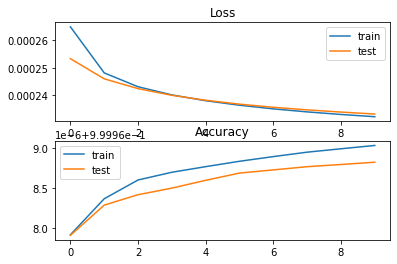

In [67]:
import matplotlib
from  matplotlib import pyplot
%matplotlib inline
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

# Model Architecture 

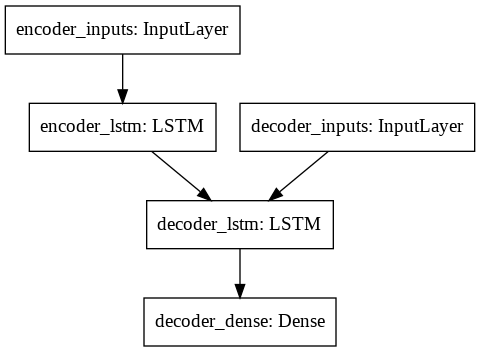

In [68]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')
from IPython.display import Image
Image(filename='model.png',height=400,width=400)

# The Model architecture is explined in the diagram above 
<br>
<p>The Encoder-Decoder <strong>Long short-term memory (LSTM) Architecture</strong> is a recurrent neural network designed to address sequence-to-sequence problems, sometimes called seq2seq.</p><p>Sequence-to-sequence prediction problems are challenging because the number of items in the input and output sequences can vary. For example, text translation and learning to execute programs are examples of seq2seq problems.</p><p>This architecture is comprised of two models: one for reading the input sequence and encoding it into a fixed-length vector, and a second for decoding the fixed-length vector and outputting the predicted sequence. The use of the models in concert gives the architecture its name of Encoder-Decoder LSTM designed specifically for seq2seq problems.</p>
<p>The model consists of 3 parts: encoder, intermediate (encoder) vector and decoder.</p>
<strong>Encoder</strong><br>
A stack of several recurrent units (LSTM or GRU cells for better performance) where each accepts a single element of the input sequence, collects information for that element and propagates it forward.
In question-answering problem, the input sequence is a collection of all words from the question. Each word is represented as x_i where i is the order of that word.
The hidden states h_i are computed using the formula:
\begin{equation*}
h(t)   = f(w^{hh} (ht-1) + w^{hx} (Xt))
\end{equation*}
This simple formula represents the result of an ordinary recurrent neural network. As you can see, we just apply the appropriate weights to the previous hidden state h_(t-1) and the input vector x_t.<br>
<strong>Encoder Vector</strong><br>
This is the final hidden state produced from the encoder part of the model. It is calculated using the formula above.
This vector aims to encapsulate the information for all input elements in order to help the decoder make accurate predictions.
It acts as the initial hidden state of the decoder part of the model.<br><strong>Decoder</strong><br>
A stack of several recurrent units where each predicts an output y_t at a time step t.
Each recurrent unit accepts a hidden state from the previous unit and produces and output as well as its own hidden state.
In the question-answering problem, the output sequence is a collection of all words from the answer. Each word is represented as y_i where i is the order of that word.
Any hidden state h_i is computed using the formula:
\begin{equation*}
h(t)   = f(w^{hh} (ht-1) )
\end{equation*}
As you can see, we are just using the previous hidden state to compute the next one.
The output y_t at time step t is computed using the formula:
\begin{equation*}
y(t)   = softmax(w^s*ht)
\end{equation*}
<br><p>We calculate the outputs using the hidden state at the current time step together with the respective weight W(S). Softmax is used to create a probability vector which will help us determine the final output (e.g. word in the question-answering problem)</p>

# Check-5 

• Generate the model summary<br>

In [69]:
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, None, 100)    0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     (None, None, 100)    0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 256), (None, 365568      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 256),  365568      decoder_inputs[0][0]             
                                                                 encoder_lstm[0][1]        

Save model to Local disk

In [70]:
# save model
model_json = model.to_json()
# folder to save the results
if not os.path.exists(os.path.join(os.getcwd(), '/content/lstm_model/')):
    os.mkdir('/content/lstm_model/')
if not os.path.exists(os.path.join(os.getcwd(), '/content/lstm_model/model/')):
    os.mkdir('/content/lstm_model/model/')
with open("/content/lstm_model/model/rikichatbot_lstm_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights
model.save_weights("/content/lstm_model/model/rikichatbot_lstm_model.h5")
print("Saved model to disk")

Saved model to disk


# Prediction
• Finally generate the prediction<br>

In [71]:
from keras.models import Model, model_from_json
class RikiGloveChatBot(object):
    model = None
    encoder_model = None
    decoder_model = None
    target_word2idx = None
    target_idx2word = None
    max_decoder_seq_length = None
    max_encoder_seq_length = None
    num_decoder_tokens = None
    word2em = None
    def __init__(self):
        self.word2em = load_glove()
        #print(len(self.word2em))
        #print(self.word2em['start'])
        self.target_word2idx = np.load(
            '/content/' + DATA_SET_NAME + '/word-glove-target-word2idx.npy',allow_pickle=True).item()
        self.target_idx2word = np.load(
            '/content/' + DATA_SET_NAME + '/word-glove-target-idx2word.npy',allow_pickle=True).item()
        context = np.load('/content/' + DATA_SET_NAME + '/word-glove-context.npy',allow_pickle=True).item()
        self.max_encoder_seq_length = context['encoder_max_seq_length']
        self.max_decoder_seq_length = context['decoder_max_seq_length']
        self.num_decoder_tokens = context['num_decoder_tokens']
        encoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE), name='encoder_inputs')
        encoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, name="encoder_lstm")
        encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
        encoder_states = [encoder_state_h, encoder_state_c]

        decoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE), name='decoder_inputs')
        decoder_lstm = LSTM(units=HIDDEN_UNITS, return_sequences=True, return_state=True, name='decoder_lstm')
        decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
        decoder_dense = Dense(self.num_decoder_tokens, activation='softmax', name='decoder_dense')
        decoder_outputs = decoder_dense(decoder_outputs)

        self.model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

        model_json = open('/content/models/' + DATA_SET_NAME + '/word-glove-architecture.json', 'r').read()
        self.model = model_from_json(model_json)
        self.model.load_weights('/content/' + DATA_SET_NAME + '/word-glove-weights.h5')
        self.model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

        self.encoder_model = Model(encoder_inputs, encoder_states)

        decoder_state_inputs = [Input(shape=(HIDDEN_UNITS,)), Input(shape=(HIDDEN_UNITS,))]
        decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_state_inputs)
        decoder_states = [state_h, state_c]
        decoder_outputs = decoder_dense(decoder_outputs)
        self.decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs] + decoder_states)


    def reply(self, input_text):
        input_seq = []
        input_emb = []
        for word in nltk.word_tokenize(input_text.lower()):
            if not in_white_list(word):
                #continue
                emb = np.zeros(shape=GLOVE_EMBEDDING_SIZE)
            if word in self.word2em:
                emb = self.word2em[word]
            input_emb.append(emb)
        input_seq.append(input_emb)
        input_seq = pad_sequences(input_seq, self.max_encoder_seq_length)
        states_value = self.encoder_model.predict(input_seq)
        target_seq = np.zeros((1, 1, GLOVE_EMBEDDING_SIZE))
        target_seq[0, 0, :] = self.word2em['start']
        target_text = ''
        target_text_len = 0
        terminated = False
        while not terminated:
            output_tokens, h, c = self.decoder_model.predict([target_seq] + states_value)
            sample_token_idx = np.argmax(output_tokens[0, -1, :])
            sample_word = self.target_idx2word[sample_token_idx]
            target_text_len += 1
            if sample_word != 'start' and sample_word != 'end':
                target_text += ' ' + sample_word
            if sample_word == 'end' or target_text_len >= self.max_decoder_seq_length:
                terminated = True
            target_seq = np.zeros((1, 1, GLOVE_EMBEDDING_SIZE))
            if sample_word in self.word2em:
                target_seq[0, 0, :] = self.word2em[sample_word]
            states_value = [h, c]
        return target_text.strip()
    def test_run(self):
        print("Test Query 1 : Who knows?  All I've ever heard her say is that she'd dip before dating a guy that smokes. ")
        print(" ")
        print(self.reply("Who knows?  All I've ever heard her say is that she'd dip before dating a guy that smokes."))
        print(" ")
        print("Test Query 2 : How are you ? ")
        print("  ")
        print(self.reply("How are you ?"))
        print("  ")
        print("Test Query 3 : Is he oily or dry? ")
        print(self.reply("Is he oily or dry?"))
def main():
    model = RikiGloveChatBot()
    model.test_run()

if __name__ == '__main__':
    main()

Test Query 1 : Who knows?  All I've ever heard her say is that she'd dip before dating a guy that smokes. 
 
vicki geordi applejack havent meals vicki score vicki watches crashes score luck luck vicki luck vicki luck tension luck luck luck killing killing luck killing killing probably luck vicki killing luck killing luck killing killing luck killing luck killing killing troubles cut
 
Test Query 2 : How are you ? 
  
vicki university vicki woman sweating geordi cut luck luck luck luck luck killing killing luck killing killing luck killing killing troubles cut luck killing luck killing luck killing killing luck killing killing troubles cut luck killing luck killing luck killing killing luck
  
Test Query 3 : Is he oily or dry? 
vicki vicki england geordi watches estimate g-d vicki fin selectman selectman hiya promised vicki fin gaston geordi prayed fin studying selectman von cone necks meltdown worries score luck luck luck luck killing killing killing killing probably luck vicki luck ki

# Project Synopsis and Summary and Conclusion

**AIM of the project and problem statement**<br>
**Aim of the Project**<br>
<p>Aim of the project is to build an intelligent conversational
chatbot, Riki, that can understand complex queries from
the user and intelligently respond.</p><br>
<strong>Background</strong><br><p>
R-Intelligence Inc., an AI startup, has partnered with an online chat and discussion website bluedit.io.
R-Intelligence Inc. has an average of over 5 million active customers across the globe and more than 100,000 active chat rooms.</p><p>
Due to the increase in traffic, R-Intelligence Inc. are looking to improve the user experience by using a chatbot moderator.</p><p>
The chatbot moderator uses a chatbot named Riki, that can help R-Intelligence Inc. customers to engage in meaningful conversation and keep them updated on trending topics.
The Artificial Intelligence-powered chat experience provides easy access to information and a host of options to the customers</p>
<br>
<strong>Problem Statement</strong><br>
<p>R-Intelligence Inc. has invested in Python, PySpark, and Tensorflow. Using emerging technologies 
of Artificial Intelligence, Machine Learning, and Natural Language Processing, Riki – the chatbot 
should make the whole conversation as realistic as talking to an actual human. </p><p>
The chatbot should understand that users have different intents and make it extremely simple 
to work around these by presenting the users with options and recommendations that best suit 
their needs.</p>
<strong>Architecture Used and Solution Implemented</strong><br>

<p>Long Short-Term Memory (LSTM) is a special kind of RNN, which has special forget gates, 
in addition to input and output gates of the simple RNN. The solution implemented for the given problem statement in the project is LSTM encoder-decoder Architecture.LSTMs are designed to remember 
the input state for a longer time than an RNN, hence allowing long sequences to be processed 
accurately. LSTMs are a fundamental part of NLP architecture for Apple, Amazon, 
Google and other tech companies.</p><p>
The model consists of 3 parts: encoder, intermediate (encoder) vector and decoder. This is already being explained along with Model architecture.</p>
<p>The use of the models in concert gives the architecture its name of Encoder-Decoder LSTM designed specifically for seq2seq problems.</p><p>
Sequence to sequence models are based on RNN architecture and consists of two RNNs: an 
encoder and a decoder. The encoder’s task is to process the input, and the decoder to process the 
output. Sequence to sequence models can be thought of as one decoder node producing output 
corresponding to one encoder node.</p><p>This model has straightforward application in machine 
translation as a corresponding word for the output language can be generated by decoder easily 
by looking only at one word of input language at a time. </p>

<strong>Real-World Applications</strong><br>
<p>There are many ways to upgrade communication between your company and its customers. One effective method (both in terms of cost and results) for any business to improve their customer service game is by using chatbots. Recently, chatbots have been applied in many different aspects of business and have had many proven records of success</p>
<li>Chatbots Answer Questions And Inquiries<p>A chatbot, thanks to its 24/7 presence and ability to reply instantly, can be of immense help. The company organizing the event can set up the chatbot to answer common questions like:
What does the ticket cost? And where do I buy it?
How do I get to the venue?</p>
<li>Book Tickets To Events/Shows With Chatbots <p>Before making a purchasing decision, most customers will ask the same types of questions regarding what they are buying. Answering such repetitive questions will take up your customer support’s valuable time and resources. 
A better solution would be to deploy a chatbot on your website and design it to answer basic questions your salespeople get regularly. These can be questions like:
Which movies are playing today?
Can I get a refund for my ticket?
Which seats are available?</p>
<li>Chatbots To Build Remarkable Customer Experience<p>Chatbots don’t have to be serious and purely transactional. You can design them to go through a buying decision by creating a ‘quiz’, telling jokes along the way, and sending the occasional meme.</p>
<li>Chatbots Can Confirm Orders And Track Shipping<p>After buying a product, customers may want to know how much time remains until their product ships.Chatbots Can be used to Confirm Orders And Track Shipping 24*7</p>
Other applications includes
<li>Chatbots Help You Collect Customer Feedback Efficiently
<li>Chatbots Assign Customer Requests To Support Teams
<li>Chatbots Generate Leads With Sales Approach
<li>Chatbots Help You Build Email Lists More Effectively
<li>Chatbots Promote Products With Fun Conversations
<br>
<strong>Conclusion</strong><br>
<p>We built an open domain generative chatbot using LSTM and seq2seq model with Tensorflow.We could be able to attain nearly same amount of value loss and accuracy loss during training which has resulted in to nearly 100% accuracy.Which shows that the training and testing was just right , and is not over or under fitting. The bot is able to capture simple entity, but most responses are pretty generic. End to end model using LSTM architecture is easy to implement, but using it alone can’t yield good result. In the future we plan to try entity recognition and larger dataset with distributed training, and might switch to retrieval based chatbot. Also the open source frameworks such as <strong>RASA or RASA-X</strong> or <strong>Google's Dialogue-Flow </strong> provides better chat bot development environment as these frameworks provide complete built in architecture defined properly with Entity recognition with limited amount of coding.</p><br>
<strong>Summary</strong><br><p>
Deep Learning is a new, exciting domain with tremendous research being carried out in this 
space. This has allowed us to create generic models to analyze large data, at scale. Deep 
Learning helps eliminate the complexity of feature engineering from the traditional machine 
learning process and truly learns the underlying data patterns. Architectures like RNN, LSTM 
and sequence to sequence model overcome the limitation of context recognition, an essential part 
of NLP. Generation-based Networks have it made possible to create a “true” chatbot whose 
responses are based only on the training data. 
These advances can be leveraged and explored to build life-like chatbots which can make 
real conversations with a human. By creating robust chatbots which can be customized according 
to the training data, large scale automation is possible.</p>
<br><br>
<strong>References</strong><br>
[1] Vyas Ajay Bhagwat - Deep Learning for Chatbots - San Jose State University<br>
[2] Snowbot: An empirical study of building chatbot using seq2seq model with different machine learning framework by Pinglei Guo,Yusi Xiang, Yunzheng Zhang, Weiting Zhan.<br>
[3] SnehaKudugunt - Deep Neural Networks  for Bot Detection- Indian Institute Of Technology Hyderabad<br>
[4] Navin Kumar Manaswi -Deep Learning  with Applications Using Python by Apress.com<br>
[5] Online medias such as kaggle, medium, analytics vidya etc.

 
